<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Fraud_Detection_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de detección temprana de anomalías y fraudes financieros multivariado con series temporales, usando Deep Learning (LSTM/Transformer) y métodos bayesianos para estimar riesgo dinámico en transacciones Mastercard a nivel global.

Detección en tiempo real de fraudes invisibles de bajo monto, usando anomalías multivariada

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
connection_db = sqlite3.connect("mastercard.db")

df_customers = pd.read_sql("SELECT * FROM customers", connection_db)
df_cards = pd.read_sql("SELECT * FROM cards", connection_db)
df_merchants = pd.read_sql("SELECT * FROM merchants", connection_db)
df_transactions = pd.read_sql("SELECT * FROM transactions", connection_db)
df_fraud_labels = pd.read_sql("SELECT * FROM fraud_labels", connection_db)

connection_db.close()

In [ ]:
class fraud_analyzer():
  def __init__(self, * ,customers=None, transactions=None, cards=None):
    self.customers = customers
    self.transactions = transactions
    self.cards = cards

  def Customers(self):
    fig, axes = plt.subplots(2,2, figsize=(16,8))
    fig.suptitle("Customers Analysis")

    axes[0,0].scatter(self.customers["age"], self.customers["income"], alpha=0.4)
    axes[0,0].set_xlabel("Age")
    axes[0,0].set_ylabel("Income")

    idcustomer_idtransaction_amount = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id", "transaction_id","amount"]]
    income_vs_amount = pd.merge(idcustomer_idtransaction_amount, self.customers, on="customer_id")[["income", "amount"]]

    axes[0,1].scatter(income_vs_amount["income"], income_vs_amount["amount"], alpha=0.2)
    axes[0,1].set_xlabel("Income")
    axes[0,1].set_ylabel("Transaction Amount")

    axes[1,0].hist(idcustomer_idtransaction_amount["customer_id"], bins=20)
    axes[1,0].set_xlabel("Customer ID")
    axes[1,0].set_ylabel("Transaction Frequency")

    data = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id","amount"]]
    data = data.groupby("customer_id").mean()

    axes[1,1].scatter(data.index, data["amount"], alpha=0.3)
    axes[1,1].set_xlabel("Customer ID")
    axes[1,1].set_ylabel("Average Transaction Amount")

fraud_analyzer = fraud_analyzer(customers=df_customers, transactions=df_transactions, cards=df_cards)

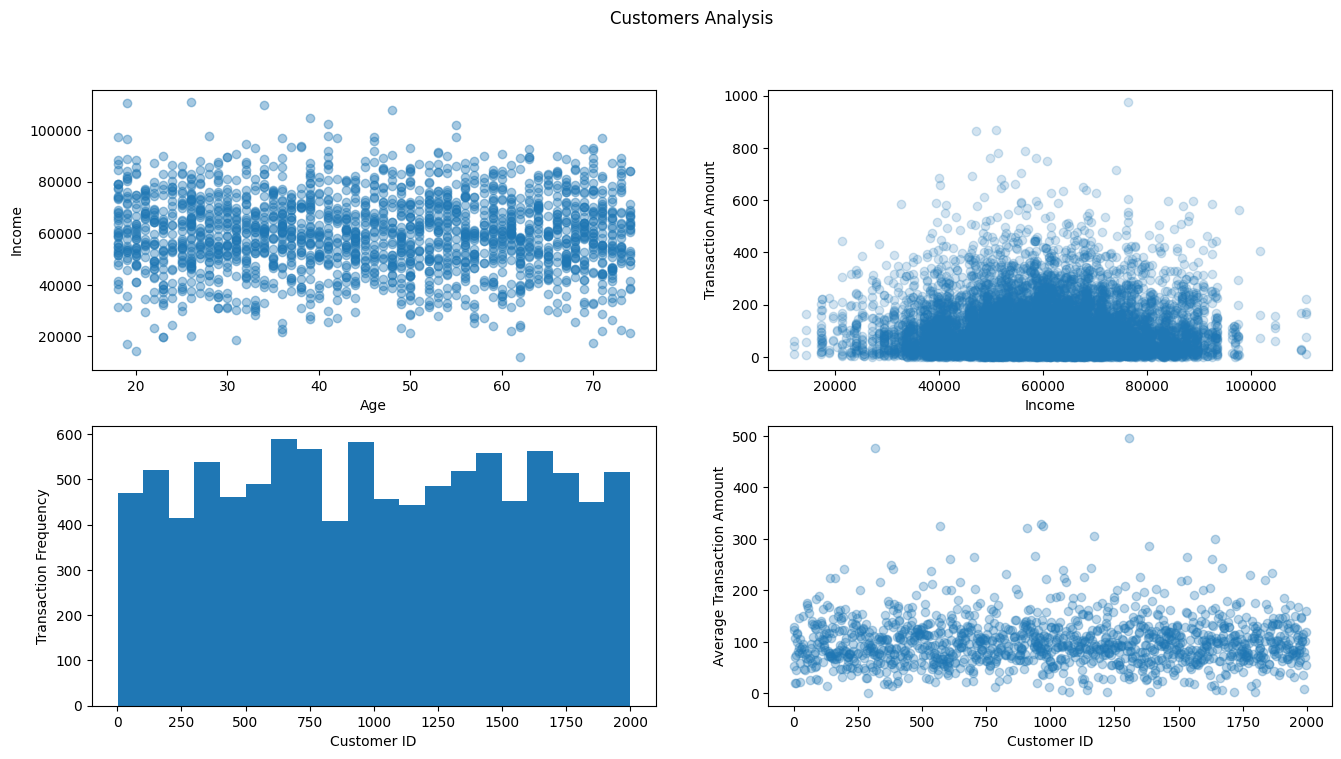

In [ ]:
fraud_analyzer.Customers()